# Criteria for LNPF

In this notebook we will investigate the inpact of using the ML or the ELBO objective for training members of LNPF.
We will also investigate the effect and/or need of using a lower bound for the standard deviation of the the latent variable and the posterior predictive.


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import logging
import os
import warnings

import matplotlib.pyplot as plt
import torch

os.chdir("../..")

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)

N_THREADS = 8
IS_FORCE_CPU = False  # Nota Bene : notebooks don't deallocate GPU memory

if IS_FORCE_CPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

torch.set_num_threads(N_THREADS)

## Initialization

Let's load the data, here we will only be working with Gaussian Processes from a single underlying kernel. For more details, see the {doc}`data <Datasets>` notebook.

In [2]:
from utils.ntbks_helpers import get_datasets_single_gp

# DATASET
gp_datasets, gp_test_datasets, gp_valid_datasets = get_datasets_single_gp()

In [3]:
gp_datasets = {k:v for k,v in gp_datasets.items() if "RBF" in k}

In [4]:
from npf.utils.datasplit import CntxtTrgtGetter, GetRandomIndcs
from utils.data import cntxt_trgt_collate

# CONTEXT TARGET SPLIT
get_cntxt_trgt_1d = cntxt_trgt_collate(
    CntxtTrgtGetter(contexts_getter=GetRandomIndcs(a=0.0, b=50))
)

Let us now make the model. We will make make one model for every member of LNPF. For each we will train them with both losses, with or without lower bound on the the std of the latent distribution, and with or without lower bound on the std of the predictive distribution.
This is a total of 24 models, so we will do in a loop. Note that besides training, the same models are used as in other notebooks.

In [5]:
from functools import partial
from npf import LNP,ConvLNP, AttnLNP
import torch
import torch.nn as nn
import torch.nn.functional as F
from npf.architectures import (
    CNN,
    MLP,
    ResConvBlock,
    SetConv,
    discard_ith_arg,
    merge_flat_input,
)
from utils.helpers import count_parameters

R_DIM = 128
KWARGS = dict(
    XEncoder=partial(MLP, n_hidden_layers=1, hidden_size=R_DIM),
    Decoder=merge_flat_input(  # MLP takes single input but we give x and R so merge them
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), is_sum_merge=True,
    ),
    r_dim=R_DIM,
)


def get_std_processing_kwargs(min_sigma_pred=0.01, min_lat=None):
    """Function returning kwarhs for processing std"""
    kwargs = dict(
        p_y_scale_transformer=lambda y_scale: min_sigma_pred
        + (1 - min_sigma_pred) * F.softplus(y_scale)
    )

    if min_lat is not None:
        kwargs["q_z_scale_transformer"] = lambda z_scale: min_lat + (
            1 - min_lat
        ) * F.softplus(z_scale)

    return kwargs


def get_lnp(
    is_mle=True, min_sigma_pred=0.01, min_lat=None,
):

    KWARGS = dict(
        is_q_zCct=not is_mle,  # use MLE instead of ELBO
        n_z_samples_train=32 if is_mle else 1,  # going to be more expensive with MLE
        n_z_samples_test=32,
        XEncoder=partial(MLP, n_hidden_layers=1, hidden_size=R_DIM),
        Decoder=merge_flat_input(  # MLP takes single input but we give x and R so merge them
            partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), is_sum_merge=True,
        ),
        r_dim=R_DIM,
        **get_std_processing_kwargs(min_sigma_pred=min_sigma_pred, min_lat=min_lat),
    )

    # 1D case
    model_1d = partial(
        LNP,
        x_dim=1,
        y_dim=1,
        XYEncoder=merge_flat_input(  # MLP takes single input but we give x and y so merge them
            partial(MLP, n_hidden_layers=2, hidden_size=R_DIM * 2), is_sum_merge=True,
        ),
        **KWARGS,
    )
    
    return model_1d


def get_attnlnp(
    is_mle=True, min_sigma_pred=0.01, min_lat=None,
):

    KWARGS = dict(
        is_q_zCct=not is_mle,  # use MLE instead of ELBO
        n_z_samples_train=8 if is_mle else 1,  # going to be more expensive
        n_z_samples_test=8,
        r_dim=R_DIM,
        attention="transformer",
        **get_std_processing_kwargs(min_sigma_pred=min_sigma_pred, min_lat=min_lat),
    )

    # 1D case
    model_1d = partial(
        AttnLNP,
        x_dim=1,
        y_dim=1,
        XYEncoder=merge_flat_input(  # MLP takes single input but we give x and y so merge them
            partial(MLP, n_hidden_layers=2, hidden_size=R_DIM), is_sum_merge=True,
        ),
        is_self_attn=False,
        **KWARGS,
    )

    return model_1d


def get_convlnp(
    is_mle=True, min_sigma_pred=0.01, min_lat=None, z_dim=None
):
    KWARGS = dict(
        is_q_zCct=not is_mle,  # use MLE instead of ELBO
        n_z_samples_train=16 if is_mle else 1, # going to be more expensive
        n_z_samples_test=16, #! DEV
        r_dim=R_DIM,
        Decoder=discard_ith_arg(
            torch.nn.Linear, i=0
        ),  # use small decoder because already went through CNN
        z_dim=16, #! NPVI requires smaller number of latent channels due to the KL
        **get_std_processing_kwargs(min_sigma_pred=min_sigma_pred, min_lat=min_lat),
    )

    CNN_KWARGS = dict(
        ConvBlock=ResConvBlock,
        is_chan_last=True,  # all computations are done with channel last in our code
        n_conv_layers=2,
        n_blocks=4,
    )

    # 1D case
    model_1d = partial(
        ConvLNP,
        x_dim=1,
        y_dim=1,
        CNN=partial(
            CNN,
            Conv=torch.nn.Conv1d,
            Normalization=torch.nn.BatchNorm1d,
            kernel_size=19,
            **CNN_KWARGS,
        ),
        density_induced=64,  # size of discretization
        is_global=False, #! Global representation does not work well with NPVI because KL before pooling
        **KWARGS,
    )

    return model_1d


lnpf_getters = dict(LNP=get_lnp, AttnLNP=get_attnlnp, ConvLNP=get_convlnp)


def get_name(lnpf, is_elbo, is_lat_LB, is_sigma_LB):
    return f"{lnpf}_ELBO{str(is_elbo)}_LatLB{str(is_lat_LB)}_SigLB{str(is_sigma_LB)}"

models = {
    get_name(lnpf, is_elbo, is_lat_LB, is_sigma_LB): lnpf_getters[
        lnpf
    ](
        is_mle=not is_elbo,
        min_sigma_pred=0.01 if is_sigma_LB else 1e-4,
        min_lat=None if is_lat_LB else 1e-4,
    )
    for lnpf in ["LNP"] 
    for is_elbo in [True, False]
    for is_sigma_LB in [True]
    for is_lat_LB in [True]
}

In [6]:
len(models)

2

### Training

The main function for training is `train_models` which trains a dictionary of models on a dictionary of datasets and returns all the trained models.
See its docstring for possible parameters.

In [ ]:
import skorch
from npf import NLLLossLNPF, ELBOLossLNPF
from utils.ntbks_helpers import add_y_dim
from utils.train import train_models

KWARGS = dict(
    is_retrain=True, # whether to load precomputed model or retrain
    chckpnt_dirname="results/pretrained/",
    device=None,  # use GPU if available
    batch_size=32,
    lr=1e-3,
    decay_lr=10,  # decrease learning rate by 10 during training
    seed=123,
    #test_datasets=gp_test_datasets,
    train_split=None,  # No need for validation as the training data is generated on the fly
    iterator_train__collate_fn=get_cntxt_trgt_1d,
    iterator_valid__collate_fn=get_cntxt_trgt_1d,
    max_epochs=100,
)

# NPVI
trainers_1d_NPVI = train_models(
    gp_datasets,
    {k:v for k,v in models.items() if "ELBOTrue" in k},
    criterion=ELBOLossLNPF,  # NPVI
    is_continue_train=True,
    **KWARGS
)

#NPML
trainers_1d_NPML = train_models(
    gp_datasets,
    {k:v for k,v in models.items() if "ELBOTrue" not in k},
    criterion=NLLLossLNPF,  # NPML
    **KWARGS
)


trainers_1d = {**trainers_1d_NPML, **trainers_1d_NPVI}


--- Training RBF_Kernel/LNP_ELBOTrue_LatLBTrue_SigLBTrue/run_0 ---



> /Neural-Process-Family/npf/neuralproc/base.py(244)_validate_inputs()
    242         """Validates the inputs by checking if features are rescaled to [-1,1] during training."""
    243         if self.training:
--> 244             if not (isin_range(X_cntxt, [-1, 1]) and isin_range(X_trgt, [-1, 1])):
    245                 raise ValueError(
    246                     f"Features during training should be in [-1,1]. {X_cntxt.min()} <= X_cntxt <= {X_cntxt.max()} ; {X_trgt.min()} <= X_trgt <= {X_trgt.max()}."



ipdb>  self.reshaper_z


*** torch.nn.modules.module.ModuleAttributeError: 'LNP' object has no attribute 'reshaper_z'


ipdb>  self.z_dim


128


ipdb>  self.r_dim


128


ipdb>  self.encoded_path


'latent'


### Plots

Let's visualize how well the model performs in different settings.

#### GPs Dataset

Let's define a plotting function that we will use in this section. We'll reuse the same function defined in {doc}`CNP notebook <CNP>`, but will use `n_samples = 20` to plot multiple posterior predictives conditioned on different latent samples.

In [8]:
from utils.ntbks_helpers import PRETTY_RENAMER, plot_multi_posterior_samples_1d
from utils.visualize import giffify


def multi_posterior_gp_gif(filename, trainers, datasets, seed=1234, **kwargs):
    giffify(
        save_filename=f"jupyter/gifs/{filename}.gif",
        gen_single_fig=plot_multi_posterior_samples_1d,  # core plotting
        sweep_parameter="n_cntxt",  # param over which to sweep
        sweep_values=[0, 2, 5, 7, 10, 15, 20, 30, 50, 100],
        fps=0.5,  # gif speed
        # PLOTTING KWARGS
        trainers=trainers,
        datasets=datasets,
        is_plot_generator=True,  # plot underlying GP
        is_plot_real=False,  # don't plot sampled / underlying function
        is_plot_std=True,  # plot the predictive std
        is_fill_generator_std=False,  # do not fill predictive of GP
        pretty_renamer=PRETTY_RENAMER,  # pretiffy names of modulte + data
        # Fix formatting for coherent GIF
        plot_config_kwargs=dict(
            set_kwargs=dict(ylim=[-3, 3]), rc={"legend.loc": "upper right"}
        ),
        seed=seed,
        **kwargs,
    )

Let us visualize the CNP when it is trained on samples from a single GP.

> /Neural-Process-Family/npf/neuralproc/base.py(244)_validate_inputs()
    242         """Validates the inputs by checking if features are rescaled to [-1,1] during training."""
    243         breakpoint()
--> 244         if self.training:
    245             if not (isin_range(X_cntxt, [-1, 1]) and isin_range(X_trgt, [-1, 1])):
    246                 raise ValueError(



ipdb>  X_cntxt


tensor([], size=(1, 0, 1))


ipdb>  X_trgt


tensor([[[-0.9922],
         [-0.9907],
         [-0.9861],
         [-0.9781],
         [-0.9767],
         [-0.9767],
         [-0.9711],
         [-0.9673],
         [-0.9670],
         [-0.9615],
         [-0.9612],
         [-0.9421],
         [-0.9350],
         [-0.9260],
         [-0.9187],
         [-0.9170],
         [-0.9074],
         [-0.8965],
         [-0.8883],
         [-0.8801],
         [-0.8753],
         [-0.8647],
         [-0.8639],
         [-0.8595],
         [-0.8552],
         [-0.8552],
         [-0.8549],
         [-0.8503],
         [-0.8403],
         [-0.8368],
         [-0.8337],
         [-0.8243],
         [-0.8197],
         [-0.8160],
         [-0.8107],
         [-0.8085],
         [-0.8038],
         [-0.7900],
         [-0.7868],
         [-0.7757],
         [-0.7752],
         [-0.7707],
         [-0.7646],
         [-0.7509],
         [-0.7502],
         [-0.7458],
         [-0.7434],
         [-0.7326],
         [-0.7317],
         [-0.7309],


ipdb>  c


> /Neural-Process-Family/npf/neuralproc/base.py(244)_validate_inputs()
    242         """Validates the inputs by checking if features are rescaled to [-1,1] during training."""
    243         breakpoint()
--> 244         if self.training:
    245             if not (isin_range(X_cntxt, [-1, 1]) and isin_range(X_trgt, [-1, 1])):
    246                 raise ValueError(



ipdb>  X_cntxt


tensor([], size=(1, 0, 1))


ipdb>  c


> /Neural-Process-Family/npf/neuralproc/base.py(244)_validate_inputs()
    242         """Validates the inputs by checking if features are rescaled to [-1,1] during training."""
    243         breakpoint()
--> 244         if self.training:
    245             if not (isin_range(X_cntxt, [-1, 1]) and isin_range(X_trgt, [-1, 1])):
    246                 raise ValueError(



ipdb>  X_cntxt


tensor([[[-0.3275],
         [ 0.8921]]])


ipdb>  c


> /Neural-Process-Family/npf/neuralproc/base.py(244)_validate_inputs()
    242         """Validates the inputs by checking if features are rescaled to [-1,1] during training."""
    243         breakpoint()
--> 244         if self.training:
    245             if not (isin_range(X_cntxt, [-1, 1]) and isin_range(X_trgt, [-1, 1])):
    246                 raise ValueError(



ipdb>  X_cntxt


tensor([[[-0.3275],
         [ 0.8921]]])


ipdb>  c


> /Neural-Process-Family/npf/neuralproc/base.py(244)_validate_inputs()
    242         """Validates the inputs by checking if features are rescaled to [-1,1] during training."""
    243         breakpoint()
--> 244         if self.training:
    245             if not (isin_range(X_cntxt, [-1, 1]) and isin_range(X_trgt, [-1, 1])):
    246                 raise ValueError(



ipdb>  X_cntxt


tensor([[[-0.3275],
         [ 0.8921],
         [ 0.5115],
         [-0.7023],
         [-0.6110]]])


ipdb>  c


> /Neural-Process-Family/npf/neuralproc/base.py(244)_validate_inputs()
    242         """Validates the inputs by checking if features are rescaled to [-1,1] during training."""
    243         breakpoint()
--> 244         if self.training:
    245             if not (isin_range(X_cntxt, [-1, 1]) and isin_range(X_trgt, [-1, 1])):
    246                 raise ValueError(



ipdb>  X_cntxt


tensor([[[-0.3275],
         [ 0.8921],
         [ 0.5115],
         [-0.7023],
         [-0.6110]]])


ipdb>  c


> /Neural-Process-Family/npf/neuralproc/base.py(244)_validate_inputs()
    242         """Validates the inputs by checking if features are rescaled to [-1,1] during training."""
    243         breakpoint()
--> 244         if self.training:
    245             if not (isin_range(X_cntxt, [-1, 1]) and isin_range(X_trgt, [-1, 1])):
    246                 raise ValueError(



ipdb>  X_cntxt


tensor([[[-0.3275],
         [ 0.8921],
         [ 0.5115],
         [-0.7023],
         [-0.6110],
         [-0.7904],
         [-0.0267]]])


ipdb>  X_cntxt


tensor([[[-0.3275],
         [ 0.8921],
         [ 0.5115],
         [-0.7023],
         [-0.6110],
         [-0.7904],
         [-0.0267]]])


ipdb>  c


> /Neural-Process-Family/npf/neuralproc/base.py(244)_validate_inputs()
    242         """Validates the inputs by checking if features are rescaled to [-1,1] during training."""
    243         breakpoint()
--> 244         if self.training:
    245             if not (isin_range(X_cntxt, [-1, 1]) and isin_range(X_trgt, [-1, 1])):
    246                 raise ValueError(



ipdb>  X_cntxt


tensor([[[-0.3275],
         [ 0.8921],
         [ 0.5115],
         [-0.7023],
         [-0.6110],
         [-0.7904],
         [-0.0267]]])


ipdb>  c


> /Neural-Process-Family/npf/neuralproc/base.py(244)_validate_inputs()
    242         """Validates the inputs by checking if features are rescaled to [-1,1] during training."""
    243         breakpoint()
--> 244         if self.training:
    245             if not (isin_range(X_cntxt, [-1, 1]) and isin_range(X_trgt, [-1, 1])):
    246                 raise ValueError(



ipdb>  X_cntxt


tensor([[[-0.3275],
         [ 0.8921],
         [ 0.5115],
         [-0.7023],
         [-0.6110],
         [-0.7904],
         [-0.0267],
         [-0.1213],
         [-0.9772],
         [ 0.7362]]])


ipdb>  X_trgt


tensor([[[-0.9965],
         [-0.9962],
         [-0.9854],
         [-0.9833],
         [-0.9822],
         [-0.9807],
         [-0.9780],
         [-0.9772],
         [-0.9715],
         [-0.9714],
         [-0.9657],
         [-0.9656],
         [-0.9607],
         [-0.9585],
         [-0.9575],
         [-0.9454],
         [-0.9426],
         [-0.9378],
         [-0.9335],
         [-0.9315],
         [-0.9289],
         [-0.9233],
         [-0.9194],
         [-0.9056],
         [-0.9035],
         [-0.9008],
         [-0.8991],
         [-0.8939],
         [-0.8934],
         [-0.8847],
         [-0.8803],
         [-0.8779],
         [-0.8757],
         [-0.8714],
         [-0.8668],
         [-0.8541],
         [-0.8457],
         [-0.8396],
         [-0.8395],
         [-0.8269],
         [-0.8179],
         [-0.8043],
         [-0.8018],
         [-0.7904],
         [-0.7823],
         [-0.7781],
         [-0.7633],
         [-0.7581],
         [-0.7558],
         [-0.7510],


ipdb>  q


BdbQuit: 

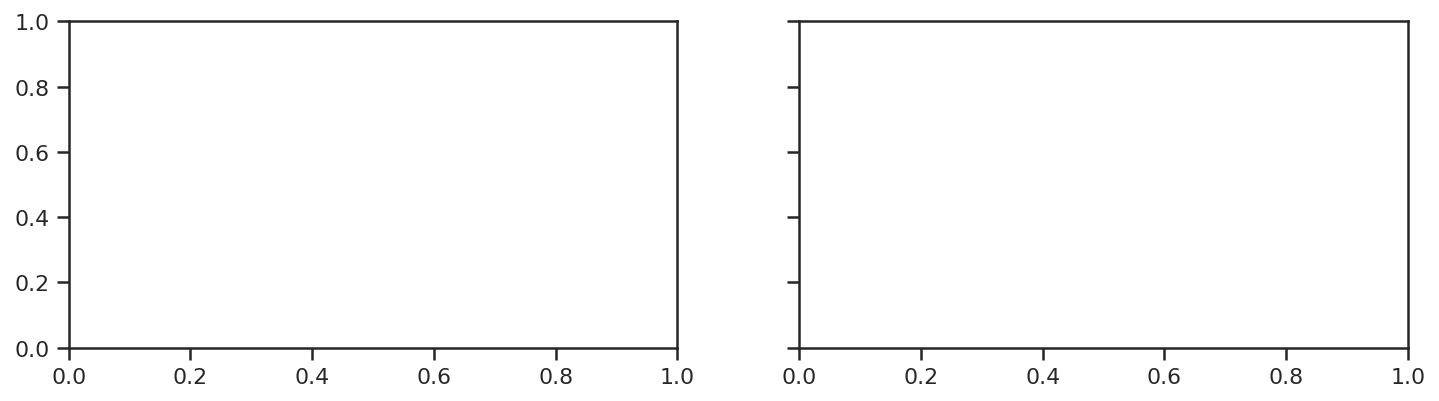

In [9]:
def filter_npf(d, lnpf, is_elbo, is_lat_LB, is_sigma_LB):
    """Select only data form single GP."""
    return {k: v for k, v in d.items() if "/"+get_name(lnpf, is_elbo, is_lat_LB, is_sigma_LB) in k}

for lnpf in ["LNP"]:
    for is_sigma_LB in [True]:
        for is_lat_LB in [True]:
            multi_posterior_gp_gif(
                f"test_singlegp_{lnpf}_LatLB{str(is_lat_LB)}_SigLB{str(is_sigma_LB)}",
                trainers=filter_npf(trainers_1d, lnpf, is_elbo=False, is_lat_LB=is_lat_LB, is_sigma_LB=is_sigma_LB),
                trainers_compare=filter_npf(trainers_1d, lnpf, is_elbo=True, is_lat_LB=is_lat_LB, is_sigma_LB=is_sigma_LB),
                datasets=gp_datasets,
                n_samples=20,  # 20 samples from the latent
                title="{model_name} | {data_name} | C={n_cntxt}",
                imgsize=(6, 3),
            )

In [15]:
gp_datasets['RBF_Kernel'].n_points = 40

Let's now visualize all of these plots.

### LNP

#### No Lower bounds

```{figure} ../gifs/singlegp_LNP_LatLBFalse_SigLBFalse.gif
---
width: 60em
name: singlegp_LNP_LatLBFalse_SigLBFalse
---
```

#### Lower bounded std of latent

```{figure} ../gifs/singlegp_LNP_LatLBTrue_SigLBFalse.gif
---
width: 60em
name: singlegp_LNP_LatLBTrue_SigLBFalse
---
```

#### Lower bounded std of predictive

```{figure} ../gifs/singlegp_LNP_LatLBFalse_SigLBTrue.gif
---
width: 60em
name: singlegp_LNP_LatLBFalse_SigLBTrue
---
```

#### Both Lower Bounds


```{figure} ../gifs/singlegp_LNP_LatLBTrue_SigLBTrue.gif
---
width: 60em
name: singlegp_LNP_LatLBTrue_SigLBTrue
---
```

### AttnLNP

#### No Lower bounds

```{figure} ../gifs/singlegp_AttnLNP_LatLBFalse_SigLBFalse.gif
---
width: 60em
name: singlegp_AttnLNP_LatLBFalse_SigLBFalse
---
```

#### Lower bounded std of latent

```{figure} ../gifs/singlegp_AttnLNP_LatLBTrue_SigLBFalse.gif
---
width: 60em
name: singlegp_AttnLNP_LatLBTrue_SigLBFalse
---
```

#### Lower bounded std of predictive

```{figure} ../gifs/singlegp_AttnLNP_LatLBFalse_SigLBTrue.gif
---
width: 60em
name: singlegp_AttnLNP_LatLBFalse_SigLBTrue
---
```

#### Both Lower Bounds


```{figure} ../gifs/singlegp_AttnLNP_LatLBTrue_SigLBTrue.gif
---
width: 60em
name: singlegp_AttnLNP_LatLBTrue_SigLBTrue
---
```

### ConvLNP


```{warning} 

For NPVI to train with ConvLNP we had to remove the global representation and decrease the number of channels to `z_dim=16`.
The models for NPVI and NPML are thus slighlty different.
```


#### No Lower bounds

```{figure} ../gifs/singlegp_ConvLNP_LatLBFalse_SigLBFalse.gif
---
width: 60em
name: singlegp_ConvLNP_LatLBFalse_SigLBFalse
---
```

#### Lower bounded std of latent

```{figure} ../gifs/singlegp_ConvLNP_LatLBTrue_SigLBFalse.gif
---
width: 60em
name: singlegp_ConvLNP_LatLBTrue_SigLBFalse
---
```

#### Lower bounded std of predictive

```{figure} ../gifs/singlegp_ConvLNP_LatLBFalse_SigLBTrue.gif
---
width: 60em
name: singlegp_ConvLNP_LatLBFalse_SigLBTrue
---
```

#### Both Lower Bounds


```{figure} ../gifs/singlegp_ConvLNP_LatLBTrue_SigLBTrue.gif
---
width: 60em
name: singlegp_ConvLNP_LatLBTrue_SigLBTrue
---
```


In [11]:
###### ADDITIONAL 1D PLOTS ######

#TO Chose